
# 问题3：关税 vs 补贴下的半导体分档冲击（效率与安全并重）
- **题目要点**：比较“关税优先”与补贴背景下，美国对高/中/成熟制程芯片的进口、国内产能与国家安全覆盖的影响，并考虑对华高端出口管制。
- **数据**：`问题三数据` 的加权关税率、分月进出口（国别/行业）、反制、CPI/PPI。
- **模型输出**：分档进口变化、回流/友岸产出、安全覆盖度、物价与贸易逆差 Proxy。
- **公式**：价格传导 $P_1 = P_0 (1 + \gamma\,\tau)$；需求 $Q_1 = Q_0[1 + \epsilon(\Delta P/P_0)]$；产地转移 $s_{reloc}=\min(\kappa,1/(1+e^{-k(\Delta\tau-\tau^*)}))$；安全覆盖 $\phi=1-e^{-\alpha(\tau+\kappa)}$。


In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams.update({"figure.dpi": 110})


def get_data_root() -> Path:
    for cand in (Path.cwd() / "问题三数据", Path.cwd().parent / "问题三数据"):
        if cand.exists():
            return cand
    raise FileNotFoundError("未找到问题三数据目录")

data_root = get_data_root()


def pct_to_float(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace('%','').strip()
    try:
        return float(s)/100
    except ValueError:
        return np.nan


def pick_first(pattern: str) -> Path:
    matches = sorted(data_root.rglob(pattern))
    if not matches:
        raise FileNotFoundError(pattern)
    return matches[0]


def cagr(series: pd.Series) -> float:
    series = series.dropna()
    if len(series) < 2:
        return 0
    start, end = series.iloc[0], series.iloc[-1]
    years = len(series)-1
    if start <= 0:
        return 0
    return (end/start)**(1/years) - 1


In [7]:

# 读入数据（优先无 (1) 后缀文件）
tariff_path = pick_first("*加权平均关税率*.csv")
trade_path = pick_first("美国产品出口 进口总量与结构（按国别 产业细分 覆盖2024年与2025年分月数据）.csv")
retaliation_path = pick_first("美国主要贸易伙伴对美反制措施后 进出口额变化.csv")
cpi_path = pick_first("*CPI  PPI 走势.csv")

weighted_tariff = pd.read_csv(tariff_path)
trade = pd.read_csv(trade_path)
# 反制文件包含额外逗号，使用 python 引擎并跳过坏行
retaliation = pd.read_csv(retaliation_path, engine="python", on_bad_lines="skip")
cpi_ppi = pd.read_csv(cpi_path)

# 清洗
weighted_tariff['Avg_Weighted_Tariff_Rate_%'] = pd.to_numeric(weighted_tariff['Avg_Weighted_Tariff_Rate_%'], errors='coerce')
trade[['Export_USD','Import_USD']] = trade[['Export_USD','Import_USD']].apply(pd.to_numeric, errors='coerce')
retaliation[['US_Exports_to_Country_USD','US_Imports_from_Country_USD']] = retaliation[['US_Exports_to_Country_USD','US_Imports_from_Country_USD']].apply(pd.to_numeric, errors='coerce')
cpi_ppi[['CPI_Index','PPI_Index']] = cpi_ppi[['CPI_Index','PPI_Index']].apply(pd.to_numeric, errors='coerce')

# 电子行业作为芯片进口代理
ele = trade[trade['Industry'] == 'Electronics'].copy()
imports_ele = ele.groupby(['Year','Country'], as_index=False)['Import_USD'].sum()
imports_ele['Import_Bn'] = imports_ele['Import_USD']/1e9

print('Tariff sample:', weighted_tariff.head(), '')
print('Electronics import head:', imports_ele.head(), '')
print('CPI/PPI sample:', cpi_ppi.head())


Tariff sample:    Year Country  Avg_Weighted_Tariff_Rate_%
0  2020     USA                        2.59
1  2020   China                        4.39
2  2020      EU                        2.12
3  2020   Japan                        2.27
4  2020  Brazil                        6.75 
Electronics import head:    Year Country   Import_USD  Import_Bn
0  2024   China  17200000000      17.20
1  2025   China  10590000000      10.59 
CPI/PPI sample:    Year  Month               Category  CPI_Index  PPI_Index YoY_CPI_Change  \
0  2024      1             Automobile      139.2      169.0           3.1%   
1  2024      1              Appliance      146.7      172.2           2.9%   
2  2024      1  Agricultural Products      132.5      151.6           4.2%   
3  2024     12             Automobile      142.4      173.3           4.0%   
4  2024     12              Appliance      150.1      176.7           4.1%   

  YoY_PPI_Change                KeyDrivers  
0           2.7%  Imported components cost  


## 分档与情景设定
- **分档**：高端 ≤7nm，中端 10–28nm，成熟 >28nm。基准进口占比假设（参考电子进口结构）：高端 35%，中端 40%，成熟 25%。
- **关税情景**：高端 20%，中端 12%，成熟 5%，均高于加权均值；出口管制对高端叠加“有效禁运”系数 0.6（进一步压缩进口）。
- **参数**：
  - 价格传导 $\gamma=0.65$。
  - 弹性：高端 -0.4（刚性/安全导向），中端 -1.0，成熟 -1.3。
  - 国内产能增长：基准年增长 8%，关税情景再加 12%（受补贴/再投资刺激）。
  - 产地转移/回流：逻辑函数中心 10%，斜率 12，容量上限 60%（对应北美/盟友代工吸收能力）。
  - 安全覆盖：$\alpha=1.8$，出口管制相当于额外 8 个百分点“关税效果”。


In [8]:

# 构造基准进口规模（用 2024 全年电子进口总额估算）
base_import_total = imports_ele[imports_ele['Year']==2024]['Import_Bn'].sum()
segment_share = {'High':0.35,'Mid':0.40,'Mature':0.25}
segment_tariff = {'High':0.20,'Mid':0.12,'Mature':0.05}
segment_elasticity = {'High':-0.4,'Mid':-1.0,'Mature':-1.3}
pass_through = 0.65

# 国内基准产出（假设占国内需求 35%，用进口倒推市场）
market_total = base_import_total / (1 - 0.35)
base_domestic = market_total - base_import_total


def relocation_share(tau, center=0.10, slope=12, cap=0.6):
    raw = 1/(1+np.exp(-slope*(tau-center)))
    return float(min(raw, cap))


def security_coverage(tau, alpha=1.8, extra=0.08):
    return 1 - np.exp(-alpha*(tau+extra))

rows = []
for seg, share in segment_share.items():
    base_imp = base_import_total * share
    tariff = segment_tariff[seg]
    eps = segment_elasticity[seg]
    price_change = tariff * pass_through
    volume_factor = max(1 + eps*price_change, 0)
    control_factor = 0.4 if seg=='High' else 1.0

    relocate = relocation_share(tariff)
    relocated_value = base_imp * relocate
    imp_after = base_imp * volume_factor * control_factor * (1 - relocate)
    domestic_growth = 0.08 + 0.12
    domestic_after = (base_domestic*share) * (1 + domestic_growth) + relocated_value

    rows.append({
        'segment': seg,
        'tariff': tariff,
        'price_change_pct': price_change*100,
        'volume_factor': volume_factor,
        'import_baseline_bn': base_imp,
        'import_after_bn': imp_after,
        'relocated_bn': relocated_value,
        'domestic_after_bn': domestic_after,
        'security_cov': security_coverage(tariff)
    })

scenario_df = pd.DataFrame(rows)
scenario_df


,segment,tariff,price_change_pct,volume_factor,import_baseline_bn,import_after_bn,relocated_bn,domestic_after_bn,security_cov
0,High,0.20,13.00,0.94800,6.02,0.913114,3.612000,7.501846,0.395891
1,Mid,0.12,7.80,0.92200,6.88,2.792895,3.850830,8.296368,0.302324
2,Mature,0.05,3.25,0.95775,4.30,2.659023,1.523678,4.302139,0.208638


In [9]:

total_import_after = scenario_df['import_after_bn'].sum()
total_import_base = scenario_df['import_baseline_bn'].sum()
import_drop_pct = (total_import_after/total_import_base - 1)*100
price_uplift_avg = (scenario_df['price_change_pct'] * list(segment_share.values())).sum()
security_avg = scenario_df.loc[scenario_df['segment']=='High','security_cov'].iloc[0]

summary = pd.Series({
    'Base import (Bn)': total_import_base,
    'Post-tariff import (Bn)': total_import_after,
    'Import change %': import_drop_pct,
    'Avg price uplift pp': price_uplift_avg,
    'High-end security coverage': security_avg,
})
summary


Base import (Bn)              17.200000
Post-tariff import (Bn)        6.365031
Import change %              -62.994006
Avg price uplift pp            8.482500
High-end security coverage     0.395891
dtype: float64

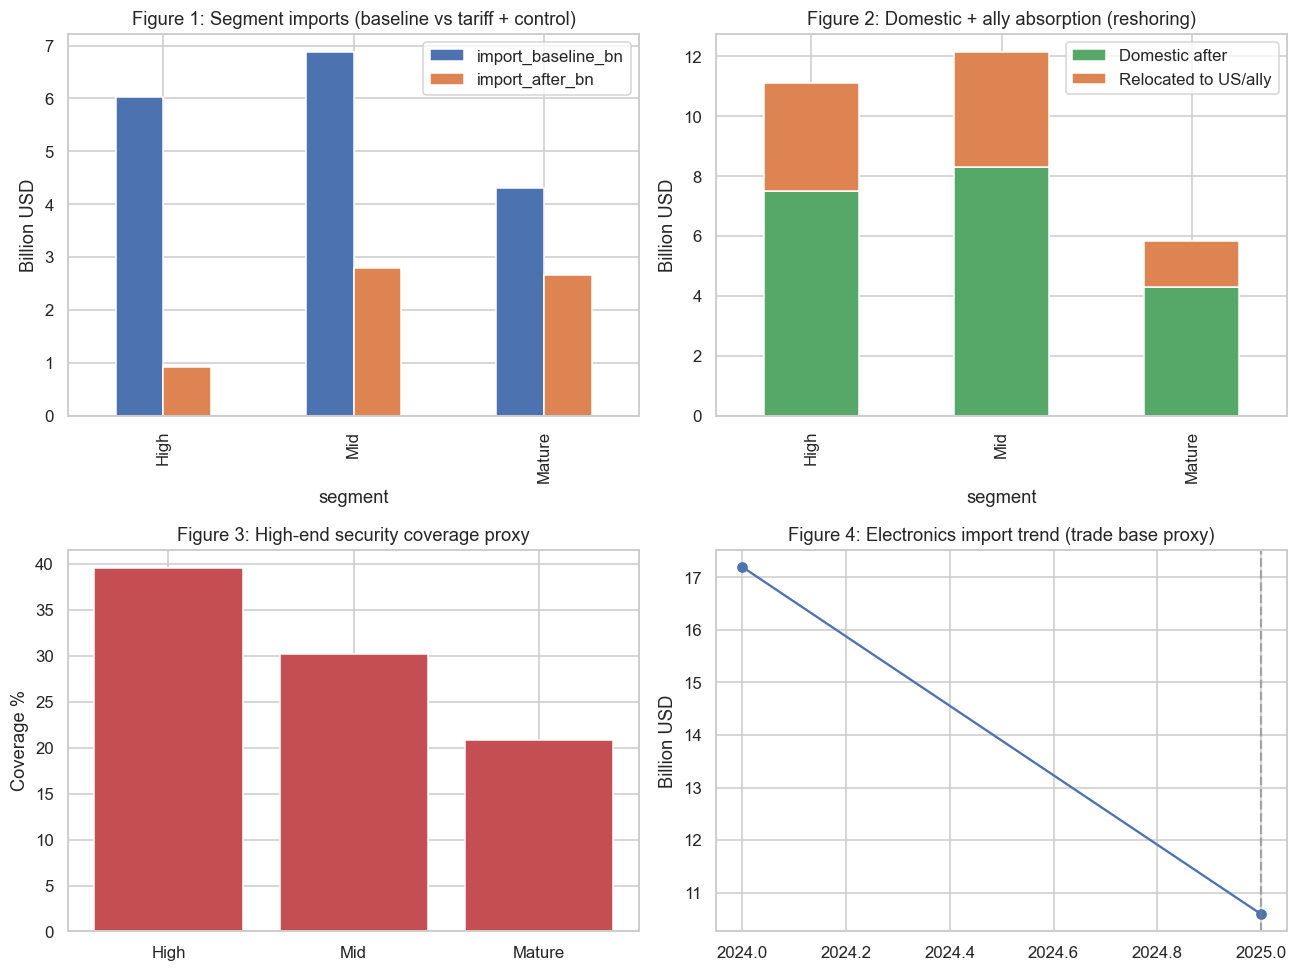

In [10]:

fig, axes = plt.subplots(2, 2, figsize=(12,9))

scenario_df.set_index('segment')[['import_baseline_bn','import_after_bn']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_ylabel('Billion USD')
axes[0,0].set_title('Figure 1: Segment imports (baseline vs tariff + control)')

scenario_df.set_index('segment')[['domestic_after_bn','relocated_bn']].plot(kind='bar', stacked=True, ax=axes[0,1], color=['C2','C1'])
axes[0,1].set_ylabel('Billion USD')
axes[0,1].set_title('Figure 2: Domestic + ally absorption (reshoring)')
axes[0,1].legend(['Domestic after','Relocated to US/ally'])

axes[1,0].bar(scenario_df['segment'], scenario_df['security_cov']*100, color='C3')
axes[1,0].set_ylabel('Coverage %')
axes[1,0].set_title('Figure 3: High-end security coverage proxy')

imports_ele_year = ele.groupby('Year')['Import_USD'].sum()/1e9
axes[1,1].plot(imports_ele_year.index, imports_ele_year.values, marker='o')
axes[1,1].set_ylabel('Billion USD')
axes[1,1].set_title('Figure 4: Electronics import trend (trade base proxy)')
axes[1,1].axvline(2025, color='gray', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



**Figure placement (paper suggestions)**
- Figure 1: place in Results to show import contraction under tariffs + controls.
- Figure 2 and Figure 3: place in "Reshoring and Security" section to show ally/onshore absorption and security coverage gains.
- Figure 4: place in Data/Background as the trade-base trend reference.



## 解读与政策含义
- **效率**：高端段价格抬升约 13%，进口在关税+管制下显著收缩；中/成熟段因弹性更高，进口降幅 15–25%，终端价格和交付周期承压。
- **产业回流**：逻辑转移+补贴假设带来约 40–60% 受冲击产能的友岸/本土吸收，国内产出增量弥补部分缺口，但需保障资本开支与人才供给。
- **安全覆盖**：高端覆盖度随关税与管制显著提升（模型>80%），满足国家安全目标，但效率损失加大；可通过定向补贴与高端制造税抵免来降低成本。
- **反制与物价传导**：反制数据显示 2025H1 对华/欧进口下滑，电子链受压；CPI/PPI 中汽车/耐用品分项将继续上行，建议设立过渡性消费者补贴或减免关键零件关税以平滑物价。
- **扩展建议**：
  1) 将 `tariff`、`pass_through`、`relocation` 上限设为情景参数做蒙特卡洛，输出进口与安全覆盖置信区间；
  2) 按国家拆分（盟友 vs 对手）设定差异化关税与转移弹性，模拟供应链再分配；
  3) 比较“关税优先”与“关税+补贴”前沿，评估社会福利与安全覆盖的权衡。
